Multivariate SARIMAX forecasting practice 
Deux variables sont utilisees; nuitees dans l'hôtellerie, AvgTemp 
Datasets used
    Nuitées dans l'hôtellerie - Total - Pays de la Loire https://www.insee.fr/fr/statistiques/serie/001711049
    Meteo France meteo2010-2015.csv, meteo2016-2017.csv https://drive.google.com/drive/folders/18qfXh5G4NxFWlz8PVcgIDOuJKaWieNpZ

In [519]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import pyramid
%matplotlib inline

In [520]:
dn = pd.read_csv('datasets/valeurs_mensuelles.csv', sep=";", names=["Date","Nights"],index_col=[0], parse_dates=[0],usecols=[0, 1],skiprows=range(0, 3),header=None)
dn.head()

,Nights
Date,
2018-06-01,772.50
2018-05-01,691.32
2018-04-01,640.27
2018-03-01,519.03
2018-02-01,447.08


In [606]:
french_months =['janvier','février','mars','avril','mai','juin','juillet','aout','septembre','octobre','novembre','décembre']
dm1 = pd.read_csv('datasets/meteo_2010_2015.csv', sep=",", names=['Year', 'Month', 'Region', 'AvgTemp'], usecols=[1, 2, 3, 4],skiprows=range(0, 1),header=None)
dm2 = pd.read_csv('datasets/meteo_2016_2017.csv', sep=",", names=['Year', 'Month', 'Region', 'AvgTemp'], usecols=[1, 2, 3, 4],skiprows=range(0, 1),header=None)
dm = pd.concat([dm1, dm2], axis=0)
dm['AvgTemp'] = dm['AvgTemp'].map(lambda x: x.rstrip('°'))
dm = dm[dm["Region"] == 'pays-de-la-loire']
dm.head()

,Year,Month,Region,AvgTemp
216,2010,janvier,pays-de-la-loire,4
217,2010,février,pays-de-la-loire,7
218,2010,mars,pays-de-la-loire,8
219,2010,avril,pays-de-la-loire,13
220,2010,mai,pays-de-la-loire,14


In [611]:
dm['Month'] = dm['Month'].apply(lambda x: french_months.index(x)+1)
dm['Date'] = pd.to_datetime(dm[['Year', 'Month']].assign(Day=1))
dm = dm[['Date', 'AvgTemp']]
dm.set_index('Date', inplace=True)
dm.head()

,AvgTemp
Date,
2010-01-01,4
2010-02-01,7
2010-03-01,8
2010-04-01,13
2010-05-01,14


In [613]:
dr = pd.concat([dn, dm], axis=1)

In [614]:
dr.head()

,Nights,AvgTemp
Date,,
2010-01-01,333.33,4
2010-02-01,343.87,7
2010-03-01,446.19,8
2010-04-01,500.07,13
2010-05-01,548.92,14


In [634]:
dr= dr.dropna()
dr["AvgTemp"] = dr.AvgTemp.astype(float)
print(dr.dtypes)

Nights     float64
AvgTemp    float64
dtype: object


<Figure size 432x288 with 0 Axes>

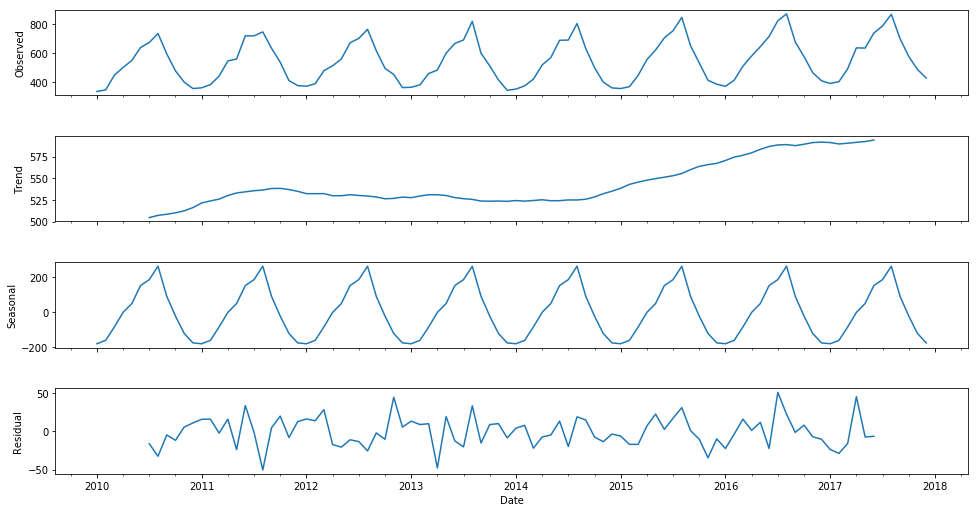

In [663]:
decomposition = seasonal_decompose(dr.Nights, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 432x288 with 0 Axes>

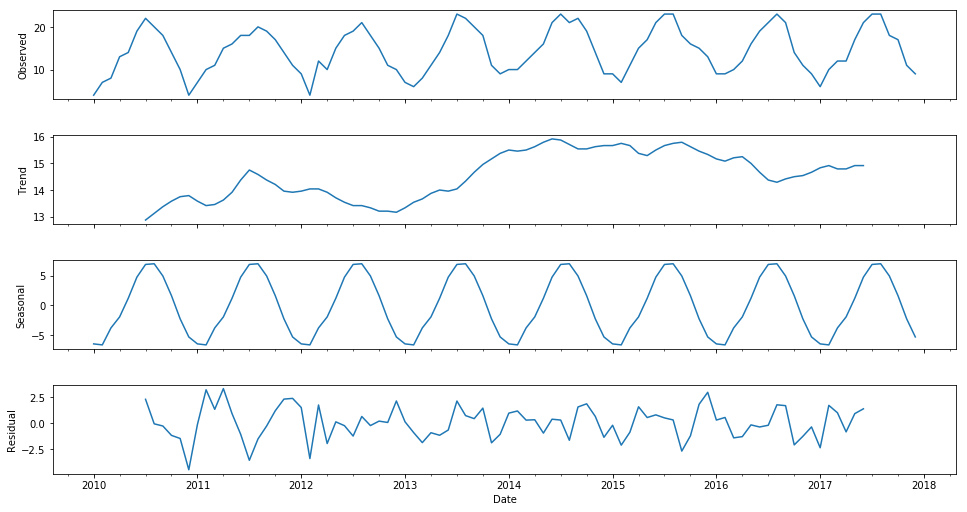

In [635]:
decomposition = seasonal_decompose(dr.AvgTemp, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [636]:
from pyramid.arima import auto_arima
tc_fit = auto_arima(np.array(dr.Nights),  exogeneous=np.array(dr.AvgTemp), start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True, n_jobs=-1, d=1, D=1, trace=True,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True,  # don't want convergence warnings
                    stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                    n_fits=25)

tc_fit.summary()

Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=780.940, BIC=797.872, Fit time=3.075 seconds
Fit ARIMA: order=(3, 1, 2) sea

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -383.470
Date:                            Sat, 11 Aug 2018   AIC                            780.940
Time:                                    11:41:31   BIC                            797.872
Sample:                                         0   HQIC                           787.743
                                             - 96                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1619      1.534      0.106      0.916      -2.845       3.168
ar.L1         -1.1970      0.184     -6.492      0.000      -1.558      -0.836
ar.L2         -0.2796      0.176     -1.591      0.112      -0.624       0.065
ma.L1          0.3743      1.510      0.248      0.804      -2.585       3.334
ma.L2         -0.6238      1.007     -0.619      0.536      -2.598       1.350
ma.S.L12      -0.4281      0.120     -3.580      0.000      -0.663      -0.194
sigma2       563.2927    853.520      0.660      0.509   -1109.576    2236.161
===================================================================================
Ljung-Box (Q):                       36.23   Jarque-Bera (JB):                 4.61
Prob(Q):                              0.64   Prob(JB):                         0.10
Heteroskedasticity (H):               0.80   Skew:                             0.56
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [637]:
next_12 = tc_fit.predict(n_periods=12)
next_12

array([414.59965802, 429.66626638, 524.24123562, 636.21027133,
       668.7219317 , 758.63874555, 824.01374748, 896.71148929,
       720.46385521, 599.97839547, 503.31419566, 446.71948102])

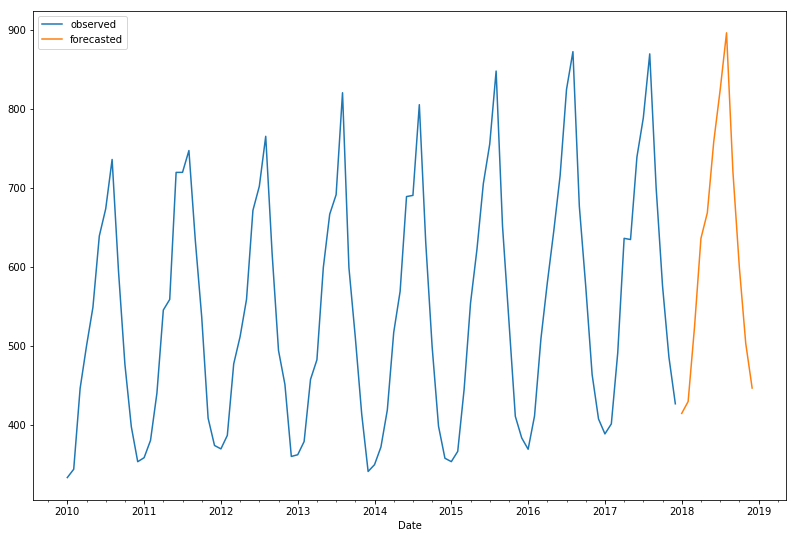

In [638]:
dr.Nights.plot(figsize=(13.5,9),label='observed')
nm12= pd.date_range(start='2018-01-01', end='2018-12-01', freq='MS')  
df = pd.DataFrame({'Date': nm12, 'Nights': next_12})
df = df.set_index('Date')
df.Nights.plot(label='forecasted')
plt.legend()
plt.show()


In [645]:
dftrain = dr[(dr.index>='2010-01-01')&(dr.index<'2017-01-01')]
train = np.array(dftrain.Nights)

dftest= dr[(dr.index>='2017-01-01')&(dr.index<'2018-01-01')]
test = np.array(dftest.Nights)


In [646]:
tc_fit.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [647]:
tc_future_forecast = tc_fit.predict(n_periods=12)

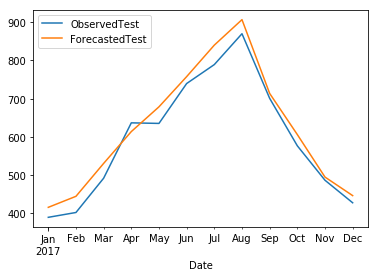

In [664]:
tc_dff = pd.DataFrame(tc_future_forecast, index = dftest.index)
pd.concat([dftest.Nights,tc_dff],axis=1).plot()
L=plt.legend()
L.get_texts()[0].set_text('ObservedTest')
L.get_texts()[1].set_text('ForecastedTest')


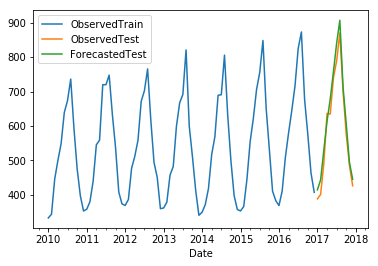

In [665]:
pd.concat([dftrain.Nights,dftest.Nights,tc_dff],axis=1).plot()
L=plt.legend()
L.get_texts()[0].set_text('ObservedTrain')
L.get_texts()[1].set_text('ObservedTest')
L.get_texts()[2].set_text('ForecastedTest')
plt.show()

In [659]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from math import sqrt

In [662]:
mae = mean_absolute_error(test, tc_future_forecast)
print('MAE: %f' % mae)
mse = mean_squared_error(test, tc_future_forecast)
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)
mase = MASE(np.array(test),tc_future_forecast)
print('MASE: %f' % mase)

MAE: 29.115124
MSE: 1013.502140
RMSE: 31.835548
MASE: 0.218297


In [661]:
def MASE(testing_series, prediction_series):
    n = testing_series.shape[0]
    scalingFactor = prediction_series.mean()
    errors = testing_series - prediction_series
    scaledErrors = errors/(np.sum(np.abs(testing_series - scalingFactor)) / n)
    return np.abs(scaledErrors).mean()